In [1]:
!pip install datasets==3.1.0
#load_dataset sometimes hangs on a higher version
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from datasets import load_dataset

import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertTokenizerFast, get_linear_schedule_with_warmup, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import json
import copy

# we set up some seeds so that we can reproduce results
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Change train.json / dev.json to the appropriate filepaths =====
data_files = {"train": "drive/MyDrive/final_project/all_train.json", "dev": "drive/MyDrive/final_project/all_dev.json"}
dataset = load_dataset('json', data_files=data_files)

```
{'name': "Stephanie Edwards (Grey's Anatomy)",
 'id': '5495190773098085777',
 'questions': [{'input_text': "when does stephanie die in grey's anatomy"}],
 'answers': [{'candidate_id': 0,
   'input_text': 'short',
   'span_end': 324,
   'span_start': 296,
   'span_text': "`` Ring of Fire '' ( 13.24 )"}],
 'has_correct_context': True,
 'contexts': "Dr. Stephanie Edwards Grey 's Anatomy character The Season 12 Promotional Photo of Jerrika Hinton as Stephanie Edwards First appearance Going , Going , Gone ( 9.01 ) September 27 , 2012 ( as recurring cast ) `` Seal Our Fate '' ( 10.01 ) September 26 , 2013 ( as series regular ) Last appearance `` Ring of Fire '' ( 13.24 ) May 18 , 2017 Created by Shonda Rhimes Portrayed by Jerrika Hinton Information Full name Stephanie Edwards Nickname ( s ) Grumpy Steph Dr. Lavender Title M.D. Significant other ( s ) Jackson Avery Kyle Diaz ( deceased )"}|

```




In [6]:

"""
Some options for BERT model that can be run in colab:

"distilbert-base-uncased",
"distilbert-base-uncased-distilled-squad",
"distilbert-base-cased",
"distilbert-base-cased-distilled-squad",

"""

'\nSome options for BERT model that can be run in colab:\n\n"distilbert-base-uncased",\n"distilbert-base-uncased-distilled-squad",\n"distilbert-base-cased",\n"distilbert-base-cased-distilled-squad",\n\n'

# Helper functions / Classes

In [26]:
class QADataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = example['questions'][0]['input_text']
        context = example['contexts']

        # Tokenize the input
        encoding = self.tokenizer(
            question,
            context,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        # Get the offset mapping and sequence ids
        offset_mapping = encoding.offset_mapping[0].tolist()
        sequence_ids = encoding.sequence_ids(0)

        # Initialize positions
        start_position = 0
        end_position = 0
        answer_type = 0

        # Process answer
        if example['answers'][0]['input_text'] != 'no_answer':
            # Get character positions
            char_start = example['answers'][0]['span_start']
            char_end = example['answers'][0]['span_end']

            # Find the context bounds
            idx = 0
            while sequence_ids[idx] != 1:
                idx += 1
            context_start = idx
            while idx < len(sequence_ids) and sequence_ids[idx] == 1:
                idx += 1
            context_end = idx - 1

            if offset_mapping[context_start][0] > char_end or \
               offset_mapping[context_end][1] < char_start:
                start_position = 0
                end_position = 0
            else:
                # Find start position
                idx = context_start
                while idx <= context_end and offset_mapping[idx][0] <= char_start:
                    idx += 1
                start_position = idx - 1

                # Find end position
                idx = context_end
                while idx >= context_start and offset_mapping[idx][1] >= char_end:
                    idx -= 1
                end_position = idx + 1

                if start_position <= end_position and start_position >= context_start:
                    answer_type = 1

        # Remove offset_mapping from encoding
        encoding.pop('offset_mapping')

        # Create the final dictionary
        encoded_dict = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'start_position': torch.tensor(start_position, dtype=torch.long),
            'end_position': torch.tensor(end_position, dtype=torch.long),
            'answer_type': torch.tensor(answer_type, dtype=torch.long),
            'question': question
        }

        return encoded_dict

In [8]:
class QAModel(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        # self.dropout = nn.Dropout(dropout_rate)
        # Should output logits for each token position
        self.qa_outputs = nn.Linear(768, 2)  # 2 for start/end logits
        self.type_outputs = nn.Linear(768, 2)  # 2 for answer type

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, 768]
        #sequence_output = self.dropout(sequence_output)

        # Get logits for each token position
        qa_logits = self.qa_outputs(sequence_output)  # [batch_size, seq_len, 2]
        start_logits, end_logits = qa_logits.split(1, dim=-1)  # Each is [batch_size, seq_len, 1]
        start_logits = start_logits.squeeze(-1)  # [batch_size, seq_len]
        end_logits = end_logits.squeeze(-1)  # [batch_size, seq_len]

        # Get answer type logits from [CLS] token
        type_logits = self.type_outputs(sequence_output[:,0])  # [batch_size, 2]

        return {
            'start_logits': start_logits,  # [batch_size, seq_len]
            'end_logits': end_logits,    # [batch_size, seq_len]
            'answer_type_logits': type_logits  # [batch_size, 2]
        }

## QAMetrics

In [30]:
class QAMetrics:
    def __init__(self, tokenizer):
        self.total_true_positives = 0
        self.total_false_positives = 0
        self.total_false_negatives = 0
        self.tokenizer = tokenizer

    def add_batch(self, predictions: tuple, references: tuple, input_ids, question=None):
        pred_starts, pred_ends = predictions
        true_starts, true_ends = references

        for i in range(len(pred_starts)):
            current_tp = 0
            current_fp = 0
            current_fn = 0

            pred_start = pred_starts[i]
            pred_end = pred_ends[i]

            # print("\n" + "="*50)
            # print(f"Sample {i}:")

            # if question is not None:
            #   print(f"\nQuestion: {question[i]}")

            pred_start_idx = pred_starts[i].item()
            pred_end_idx = pred_ends[i].item()
            true_start_idx = true_starts[i].item()
            true_end_idx = true_ends[i].item()

            # Get predicted and true tokens
            pred_tokens = input_ids[i][pred_start:pred_end + 1].tolist()
            true_tokens = input_ids[i][true_starts[i]:true_ends[i] + 1].tolist()

            # print(f"Predicted span indices: ({pred_start_idx}, {pred_end_idx})")
            # print(f"Predicted span tokens: {pred_tokens}")
            # print(f"Predicted words: '{self.tokenizer.decode(pred_tokens)}'")
            # print(f"\nTrue span indices: ({true_start_idx}, {true_end_idx})")
            # print(f"True span tokens: {true_tokens}")
            # print(f"True words: '{self.tokenizer.decode(true_tokens)}'")

            is_no_answer_pred = (pred_start == 0 and pred_end == 0)
            is_no_answer_true = (true_starts[i] == 0 and true_ends[i] == 0)

            # print("\nMetrics Update:")
            if is_no_answer_pred:
                if is_no_answer_true:
                    current_tp = 1
                    self.total_true_positives += current_tp
                else:
                    # But not increment fp as we assume CLS = no answer
                    current_fn = 1
                    self.total_false_negatives += current_fn
            else:
                if is_no_answer_true:
                    current_fp = len(pred_tokens)
                    self.total_false_positives += current_fp
                else:
                    # Token-level comparison
                    current_tp = sum(1 for token in pred_tokens if token in true_tokens)
                    current_fp = sum(1 for token in pred_tokens if token not in true_tokens)
                    current_fn = sum(1 for token in true_tokens if token not in pred_tokens)

                    self.total_true_positives += current_tp
                    self.total_false_positives += current_fp
                    self.total_false_negatives += current_fn

            # print(f"\nMetrics for this sample:")
            # print(f"TP: {current_tp}")
            # print(f"FP: {current_fp}")
            # print(f"FN: {current_fn}")


    def compute(self) -> dict:
        """
        Compute the final metrics.

        Returns:
            dict containing precision, recall, and F1 scores
        """
        precision = (self.total_true_positives /
                    (self.total_true_positives + self.total_false_positives)
                    if self.total_true_positives + self.total_false_positives > 0
                    else 0)

        recall = (self.total_true_positives /
                 (self.total_true_positives + self.total_false_negatives)
                 if self.total_true_positives + self.total_false_negatives > 0
                 else 0)

        f1 = (2 * precision * recall / (precision + recall)
              if precision + recall > 0
              else 0)

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

## compute_loss

In [10]:
def compute_loss(outputs: dict, batch: dict) -> torch.Tensor:
    """
    Compute the loss as defined in the paper:
    L = -log p(s,e,t|c) = -log pstart(s|c) - log pend(e|c) - log ptype(t|c)

    Args:
        outputs: Model outputs containing logits
        batch: Batch containing ground truth labels

    Returns:
        torch.Tensor: Total loss for the batch
    """
    # Get logits from model outputs
    start_logits = outputs['start_logits']  # [batch_size, seq_len]
    end_logits = outputs['end_logits']      # [batch_size, seq_len]
    type_logits = outputs['answer_type_logits']  # [batch_size, 2]

    # Get labels
    start_positions = batch['start_position']
    end_positions = batch['end_position']
    answer_types = batch['answer_type']

    # Compute probabilities
    start_probs = F.softmax(start_logits, dim=-1)  # [batch_size, seq_len]
    end_probs = F.softmax(end_logits, dim=-1)      # [batch_size, seq_len]
    type_probs = F.softmax(type_logits, dim=-1)    # [batch_size, 2]

    # Compute loss for each example in batch
    batch_size = start_logits.size(0)
    total_loss = 0

    for i in range(batch_size):
        # Get probabilities of correct positions
        start_prob = start_probs[i][start_positions[i]]
        end_prob = end_probs[i][end_positions[i]]
        type_prob = type_probs[i][answer_types[i]]

        # Sum negative log probabilities
        total_loss -= (torch.log(start_prob) +
                      torch.log(end_prob) +
                      torch.log(type_prob))

    # Return average loss over batch
    return total_loss / batch_size

## Load model, data, proprocess

In [11]:
def load_model():
    """
    Load the pretrained tokenizer and initialize the model.

    Returns:
        tuple: (model, tokenizer)
    """
    tokenizer = DistilBertTokenizerFast.from_pretrained(
        'distilbert-base-uncased'
    )
    model = QAModel(dropout_rate=0.1)
    return model, tokenizer

def load_data():
    """
    Load training and validation data from json files.

    Returns:
        tuple: (train_data, val_data)
    """
    train_path = 'drive/MyDrive/final_project/all_train.json'
    dev_path = 'drive/MyDrive/final_project/all_dev.json'

    with open(train_path, 'r') as f:
        train_data = json.load(f)
    with open(dev_path, 'r') as f:
        val_data = json.load(f)

    return train_data, val_data

def preprocess_and_tokenize(data, tokenizer, batch_size=64, is_training=True):
    """
    Create DataLoader for the dataset.

    Args:
        data: Raw data
        tokenizer: Tokenizer for processing text
        batch_size: Batch size for DataLoader
        is_training: Whether this is for training set (determines shuffling)
    """
    dataset = QADataset(data, tokenizer)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=is_training  # Shuffle only training data
    )
    return dataloader

## Train and eval

In [13]:
def train_loop(model, train_dataloader, val_dataloader, device, num_epochs=2):
    """
    Training loop for the model.
    Args:
        model: The QA model
        train_dataloader: DataLoader for training data (436 batches × 64 samples)
        val_dataloader: DataLoader for validation data (28 batches × 64 samples)
        device: Device to run the model on (GPU/CPU)
        num_epochs: Number of complete training cycles
    Returns:
        tuple: Lists of training and validation losses, and trained model
    """
    # Initialize optimizer with learning rate 5e-5
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    # Move model to GPU if available
    model = model.to(device)

    # Lists to track performance across epochs
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')  # Initialize best validation loss as infinity
    best_model = None             # Store best performing model

    # Main training loop - repeat for num_epochs
    for epoch in range(num_epochs):
        # === TRAINING PHASE ===
        model.train()  # Set model to training mode (enables dropout, etc.)
        total_train_loss = 0

        # Process each batch of training data
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1} Training'):
            # Move batch data to GPU/CPU, exclude question text
            batch = {k: v.to(device) for k, v in batch.items() if k != 'question'}

            # Forward pass: get model predictions
            outputs = model(batch['input_ids'], batch['attention_mask'])

            # Reset gradients from previous batch
            optimizer.zero_grad()

            # Calculate loss and backpropagate
            loss = compute_loss(outputs, batch)
            loss.backward()  # Compute gradients

            # Update model weights using calculated gradients
            optimizer.step()

            # Accumulate total loss for this epoch
            total_train_loss += loss.item()

        # Calculate average loss for this epoch
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # === VALIDATION PHASE ===
        model.eval()  # Set model to evaluation mode (disables dropout, etc.)
        total_val_loss = 0

        # No gradient calculation needed for validation
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f'Epoch {epoch+1} Validation'):
                # Move batch to device
                batch = {k: v.to(device) for k, v in batch.items() if k != 'question'}
                # Get predictions and compute loss
                outputs = model(batch['input_ids'], batch['attention_mask'])
                loss = compute_loss(outputs, batch)
                total_val_loss += loss.item()

        # Calculate average validation loss
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        # Print epoch results
        print(f'Epoch {epoch+1}:')
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Average Validation Loss: {avg_val_loss:.4f}')

    # Return training history and final model
    return train_losses, val_losses, model


def get_best_span_vectorized(start_logits, end_logits, max_span_length=30):
    """
    Compute the best span using vectorized operations.
    Paper formula:
    - g(c, s, e) = fstart(s, c; θ) + fend(e, c; θ) − fstart(s = [CLS], c; θ) − fend(e = [CLS], c; θ)
    - score = (start_logit + end_logit) - cls_score

    Args:
        start_logits: tensor of shape [seq_len], logits for start positions
        end_logits: tensor of shape [seq_len], logits for end positions
        max_span_length: maximum allowed length for the predicted span
    Returns:
        best_start: index of the best start position
        best_end: index of the best end position
    """
    seq_len = len(start_logits)

    # Get the CLS token score (used as threshold for no-answer)
    cls_score = start_logits[0] + end_logits[0]

    # Initialize score matrix [seq_len, seq_len]
    # scores[i,j] will contain the score for span from position i to j
    scores = torch.zeros((seq_len, seq_len), device=start_logits.device)

    # Calculate scores for all valid spans
    # A span is valid if:
    # 1. start_idx <= end_idx
    # 2. length <= max_span_length
    for start_idx in range(seq_len):
        # Only consider end positions that:
        # 1. Come after the start position
        # 2. Are within max_span_length tokens of the start

        # Apparently this implementation is much faster in GPU
        valid_ends = slice(start_idx, min(seq_len, start_idx + max_span_length))

        # Calculate span scores and subtract CLS score
        # This implements the paper's scoring function:
        # score = (start_logit + end_logit) - cls_score
        span_scores = start_logits[start_idx] + end_logits[valid_ends]
        scores[start_idx, valid_ends] = span_scores - cls_score

    # Find the highest scoring span
    flat_scores = scores.view(-1)
    best_idx = torch.argmax(flat_scores)

    # Convert flat index back to 2D coordinates
    best_start = best_idx // seq_len
    best_end = best_idx % seq_len

    return best_start, best_end

def eval_loop(model, val_dataloader, device, tokenizer):
    """
    Evaluation loop for computing metrics.

    Args:
        model: The QA model
        val_dataloader: DataLoader for validation data
        device: Device to run the model on
        tokenizer: Tokenizer for converting ids back to tokens

    Returns:
        tuple: (precision, recall, f1_score)
    """
    model.eval()
    metrics = QAMetrics(tokenizer)

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc='Evaluating'):
            # Prepare inputs
            model_inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            outputs = model(**model_inputs)

            # Get predictions
            start_logits = outputs['start_logits']  # [batch_size, seq_len]
            end_logits = outputs['end_logits']      # [batch_size, seq_len]
            batch_size = start_logits.size(0)

            # Store predictions
            pred_starts = []
            pred_ends = []

            # Process each example in batch
            for i in range(batch_size):
                start_logits_i = start_logits[i]
                end_logits_i = end_logits[i]

                # Get best span using vectorized computation
                best_start, best_end = get_best_span_vectorized(
                    start_logits_i,
                    end_logits_i,
                    max_span_length=30
                )

                pred_starts.append(best_start)
                pred_ends.append(best_end)

            # Convert to tensors
            pred_starts = torch.tensor(pred_starts, device=device)
            pred_ends = torch.tensor(pred_ends, device=device)

            # Update metrics
            metrics.add_batch(
                predictions=(pred_starts, pred_ends),
                references=(batch['start_position'], batch['end_position']),
                input_ids=batch['input_ids'],
                question=batch['question']
            )

    # Get results and return in same format as original
    results = metrics.compute()
    return results['precision'], results['recall'], results['f1']

## Plot

In [34]:
def plot_training_curves(train_losses, val_losses):
    """Helper function to plot training curves"""
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    except ImportError:
        print("Matplotlib not available for plotting")

# Main

Using device: cuda
Loading model and tokenizer...
Loading data...
Train examples: 27866, Validation examples: 1743
Creating dataloaders...

Starting training...


Epoch 1 Validation: 100%|██████████| 28/28 [00:27<00:00,  1.00it/s]


Epoch 1:
Average Training Loss: 3.8570
Average Validation Loss: 2.7140


Epoch 2 Validation: 100%|██████████| 28/28 [00:27<00:00,  1.01it/s]


Epoch 2:
Average Training Loss: 2.1969
Average Validation Loss: 2.4905

Evaluating best model...


Evaluating: 100%|██████████| 28/28 [01:06<00:00,  2.39s/it]



Final Metrics:
PRECISION: 0.631
RECALL: 0.597
F1-SCORE: 0.613


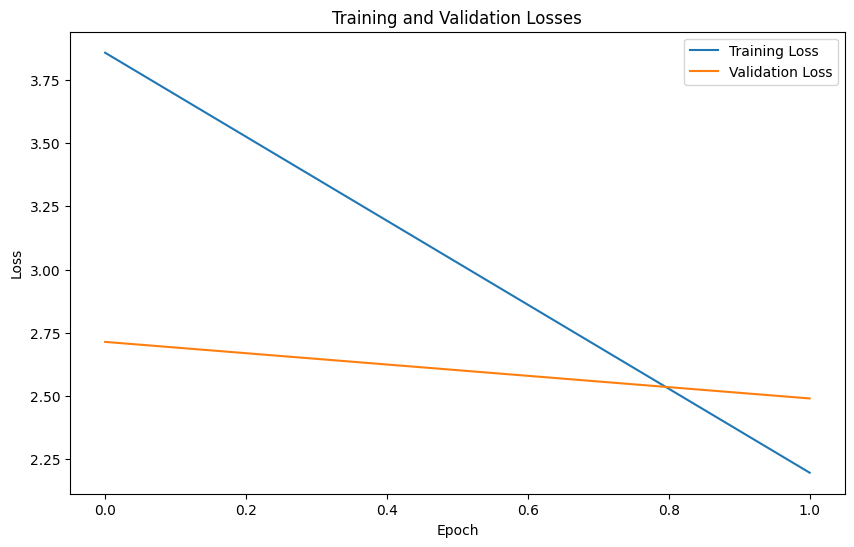

In [33]:
def main():
    # Set device and hyperparameters
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 64
    num_epochs = 2
    print(f"Using device: {device}")

    try:
        # Load model and data
        print("Loading model and tokenizer...")
        model, tokenizer = load_model()
        model = model.to(device)

        print("Loading data...")
        train_data, val_data = load_data()
        print(f"Train examples: {len(train_data)}, Validation examples: {len(val_data)}")

        # Create dataloaders
        print("Creating dataloaders...")
        train_dataloader = preprocess_and_tokenize(train_data, tokenizer, batch_size, is_training=True)
        val_dataloader = preprocess_and_tokenize(val_data, tokenizer, batch_size, is_training=False)

        # Train the model
        print("\nStarting training...")
        train_losses, val_losses, best_model = train_loop(
            model,
            train_dataloader,
            val_dataloader,
            device,
            num_epochs=num_epochs
        )

        # Evaluate best model
        print("\nEvaluating best model...")
        precision, recall, f1_score = eval_loop(best_model, val_dataloader, device, tokenizer)

        # Print final metrics
        print("\nFinal Metrics:")
        print(f"PRECISION: {precision:.3f}")
        print(f"RECALL: {recall:.3f}")
        print(f"F1-SCORE: {f1_score:.3f}")

        # Plot training curves
        plot_training_curves(train_losses, val_losses)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

# Appendix - previous debugging process
- noticed span can end < start -> check span creation process and noticed paper implementation is wrong
- noticed precision is super low and FP is quite high -> from long prediction -> limit span size

```
Sample 48:
-----------------

Predicted span indices: (67, 0)
Predicted span tokens: tensor([], device='cuda:0', dtype=torch.int64)
Predicted words: ''

True span indices: (82, 99)
True span tokens: tensor([3248, 1037, 3145, 2535, 1999, 17886, 3258, 1997, 8171, 1010,
       2011, 2552, 17441, 17886, 3512, 16285, 1010, 1998, 2437, 13749,
       17944, 8171, 4895, 22401, 2140, 2061, 2008, 17886, 3512, 16285,
       3338, 2091, 1996, 2146, 8859, 1997, 13096, 12737],
      device='cuda:0')
True words: 'plays a key role in digestion of proteins, by activating digestive enzymes, and making ingested proteins unravel so that digestive enzymes break down the long chains of amino acids'

Metrics for this sample:
TP: 0
FP: 0
FN: 38
```

```
Sample 17:

Question: who did johnny manziel play college football for
Predicted span indices: (84, 103)
Predicted span tokens: [3146, 1037, 1004, 1049, 5088, 4433, 1024, 2297, 1013, 2461, 1024, 1015, 1013, 4060, 1024, 2570, 2476, 2381, 6044, 13240]
Predicted words: 'texas a & m nfl draft : 2014 / round : 1 / pick : 22 career history cleveland browns'

True span indices: (84, 87)
True span tokens: [3146, 1037, 1004, 1049]
True words: 'texas a & m'

Metrics Update:

Metrics for this sample:
TP: 4
FP: 16
FN: 0
```

```
Sample 56:

Question: who produced the movie i can only imagine
Predicted span indices: (23, 126)
Predicted span tokens: [15837, 5416, 4901, 2091, 2229, 22514, 3393, 7959, 6299, 11021, 11876, 12662, 6969, 11895, 19771, 8202, 7638, 5671, 3533, 14161, 7361, 2361, 9000, 2011, 6285, 22209, 12895, 23680, 2953, 19099, 2466, 2011, 4074, 29433, 6285, 22209, 12895, 23680, 2953, 19099, 2241, 2006, 1996, 2166, 2466, 1997, 12075, 4971, 4232, 4626, 1046, 1012, 2745, 29194, 16974, 10767, 7637, 4748, 14322, 25193, 13182, 2099, 18856, 21239, 24520, 2386, 6877, 24209, 14326, 2189, 2011, 12895, 23680, 2953, 19099, 16434, 19031, 14399, 5886, 5035, 4115, 5493, 2011, 4080, 22209, 12895, 23680, 2953, 19099, 2537, 3316, 4901, 2091, 2229, 5453, 3260, 4620, 2248, 5500, 2011, 7212, 5867, 25131, 13051]
Predicted words: 'cindy bond kevin downes daryl lefever mickey liddell pete shilaimon raymond harris joe knopp screenplay by jon erwin brent mccorkle story by alex cramer jon erwin brent mccorkle based on the life story of bart millard starring j. michael finley madeline carroll trace adkins priscilla shirer cloris leachman dennis quaid music by brent mccorkle cinematography kristopher kimlin edited by andrew erwin brent mccorkle production companies kevin downes productions mission pictures international distributed by lionsgate roadside attractions'

True span indices: (23, 44)
True span tokens: [15837, 5416, 4901, 2091, 2229, 22514, 3393, 7959, 6299, 11021, 11876, 12662, 6969, 11895, 19771, 8202, 7638, 5671, 3533, 14161, 7361, 2361]
True words: 'cindy bond kevin downes daryl lefever mickey liddell pete shilaimon raymond harris joe knopp'

Metrics Update:

Metrics for this sample:
TP: 25
FP: 79
FN: 0
```

```
==================================================
Sample 57:

Question: where is nuclear energy used most in the world
Predicted span indices: (23, 36)
Predicted span tokens: [2885, 1010, 2167, 2637, 1010, 2264, 4021, 1998, 2148, 4021, 1012, 1996, 2142, 2163]
Predicted words: 'europe, north america, east asia and south asia. the united states'

True span indices: (35, 36)
True span tokens: [2142, 2163]
True words: 'united states'

Metrics Update:

Metrics for this sample:
TP: 2
FP: 12
FN: 0
```